### Presented at <a href="http://qvik.fi/"><img style="height:100px" src="https://qvik.com/wp-content/themes/qvik/images/qvik-logo-dark.png"/></a>
### Session-based recommender Systems: Hands-on GRU4Rec 
#### Frederick Ayala Gómez, PhD Student in Computer Science at ELTE University. Visiting Researcher at Aalto's Data Mining Group
##### Let's keep in touch!
Twitter: https://twitter.com/fredayala <br/>
LinkedIn: https://linkedin.com/in/frederickayala <br/>
GitHub: https://github.com/frederickayala
<hr/>

- Few notes:
    - This notebook was tested on Windows and presents how to use GRU4Rec
    - The paper of GRU4Rec is: B. Hidasi, et al. 2015 “Session-based recommendations with recurrent neural networks”. CoRR
    - The poster of this paper can be found in http://www.hidasi.eu/content/gru4rec_iclr16_poster.pdf
    - For OSx and Linux, CUDA, Theano and Anaconda 'might' need some extra steps
    - On Linux Desktop (e.g. Ubuntu Desktop ), **be careful** with installing CUDA and NVIDIA drivers. It 'might' break lightdm 🙈🙉🙊
    - An NVIDIA GEFORCE GTX 980M was used
    - The starting point of this notebook is the original version from Balázs Hidasi's GRU4REC repository.
    - It's recommended to use Anaconda to install stuff easier

- Installation steps:
    - Install *CUDA 8.0* from https://developer.nvidia.com/cuda-downloads
        - Optional: Install cuDNN https://developer.nvidia.com/cudnn
    - Install *Anaconda 4.3.1* for *Python 3.6* from https://www.continuum.io/downloads
    - Open Anaconda Navigator
        - Go to Enviroments / Create / Python Version 3.6 and give some name
        - In Channels, add: conda-forge then click on Update index...
        - Click on your enviroment Play arrow and choose Open Terminal
        - Install the libraries that we need:
            - conda install numpy scipy pandas mkl-service libpython m2w64-toolchain nose nose-parameterized sphinx pydot-ng
            - conda install theano pygpu
            - conda install matplotlib seaborn statsmodels
    - Create a .theanorc file in your home directory and add the following: <br/>
        [global] <br/>
        device = cuda <br/>
        \# Only if you want to use cuDNN <br/>
        [dnn]<br/>
        include_path=/path/to/cuDNN/include <br/>
        library_path=/path/to/cuDNN/lib/x64
- Get the GRU4Rec code and the dataset
    - GRU4Rec:
        - git clone https://github.com/hidasib/GRU4Rec.git
    - YOOCHOOSE Dataset:
        - http://2015.recsyschallenge.com/challenge.html
    - To get the training and testing files we have to preprocess the original dataset.
        - Go to the terminal that is running your anaconda enviroment
        - Navigate to the GRU4Rec folder
        - Edit the file GRU4Rec/examples/rsc15/preprocess.py and modify the following variables:
            - PATH_TO_ORIGINAL_DATA *The path to the input raw dataset*
            - PATH_TO_PROCESSED_DATA *The path to where you want the output*
        - Run the command: python preprocess.py
        - This will take some time, when the process ends you will have the files *rsc15_train_full.txt* and *rsc15_test.txt* in your *PATH_TO_PROCESSED_DATA* path
    - Place this notebook in the folder GRU4Rec/examples/rsc15/
- That's it! we are ready to run GRU4Rec

In [1]:
# -*- coding: utf-8 -*-
import theano
import pickle
import sys
import os
sys.path.append('../..')
import numpy as np
import pandas as pd
import gru4rec #If this shows an error probably the notebook is not in GRU4Rec/examples/rsc15/
import evaluation

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 980M (0000:01:00.0)


In [2]:
# Validate that the following assert makes sense in your platform
# This works on Windows with a NVIDIA GPU
# In other platforms theano.config.device gives other things than 'cuda' when using the GPU
assert 'cuda' in theano.config.device,("Theano is not configured to use the GPU. Please check .theanorc. "
                                       "Check http://deeplearning.net/software/theano/tutorial/using_gpu.html")

#### Update PATH_TO_TRAIN and PATH_TO_TEST to the path for rsc15_train_full.txt and rsc15_test.txt respectively 

In [3]:
PATH_TO_TRAIN = 'C:/Users/frede/datasets/recsys2015/rsc15_train_full.txt'
PATH_TO_TEST = 'C:/Users/frede/datasets/recsys2015/rsc15_test.txt'

data = pd.read_csv(PATH_TO_TRAIN, sep='\t', dtype={'ItemId':np.int64})
valid = pd.read_csv(PATH_TO_TEST, sep='\t', dtype={'ItemId':np.int64})

#### Let's take a look to the datasets

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

C:\Users\frede\Anaconda3\envs\tf\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#####  Sneak Peak to the dataset

In [5]:
data.head()

,SessionId,ItemId,Time
0,1,214536502,1.396857e+09
1,1,214536500,1.396857e+09
2,1,214536506,1.396857e+09
3,1,214577561,1.396857e+09
4,2,214662742,1.396868e+09


In [6]:
valid.head()

,SessionId,ItemId,Time
0,11265009,214586805,1.411993e+09
1,11265009,214509260,1.411993e+09
2,11265017,214857547,1.412007e+09
3,11265017,214857268,1.412007e+09
4,11265017,214857260,1.412007e+09


In [7]:
sessions_training = set(data.SessionId)
print("There are %i sessions in the training dataset" % len(sessions_training))
sessions_testing = set(valid.SessionId)
print("There are %i sessions in the testing dataset" % len(sessions_testing))
assert len(sessions_testing.intersection(sessions_training)) == 0, ("Huhu!"
                                                                    "there are sessions from the testing set in"
                                                                    "the training set")
print("Sessions in the testing set doesn't exist in the training set")

There are 7966257 sessions in the training dataset
There are 15324 sessions in the testing dataset
Sessions in the testing set doesn't exist in the training set


In [8]:
items_training = set(data.ItemId)
print("There are %i items in the training dataset" % len(items_training))
items_testing = set(valid.ItemId)
print("There are %i items in the testing dataset" % len(items_testing))
assert items_testing.issubset(items_training), ("Huhu!"
                                                "there are items from the testing set "
                                                "that are not in the training set")
print("Items in the testing set exist in the training set")

There are 37483 items in the training dataset
There are 6751 items in the testing dataset
Items in the testing set exist in the training set


In [9]:
df_visualization = data.copy()
df_visualization["value"] = 1
df_item_count = df_visualization[["ItemId","value"]].groupby("ItemId").sum()

In [10]:
# Most of the items are infrequent
df_item_count.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,37483.0,844.042339,3155.62772,1.0,16.0,77.0,368.0,132658.0


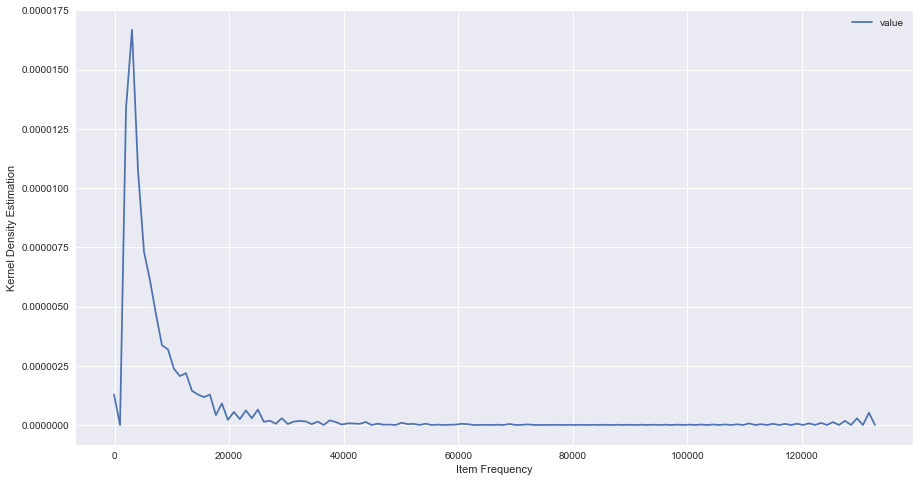

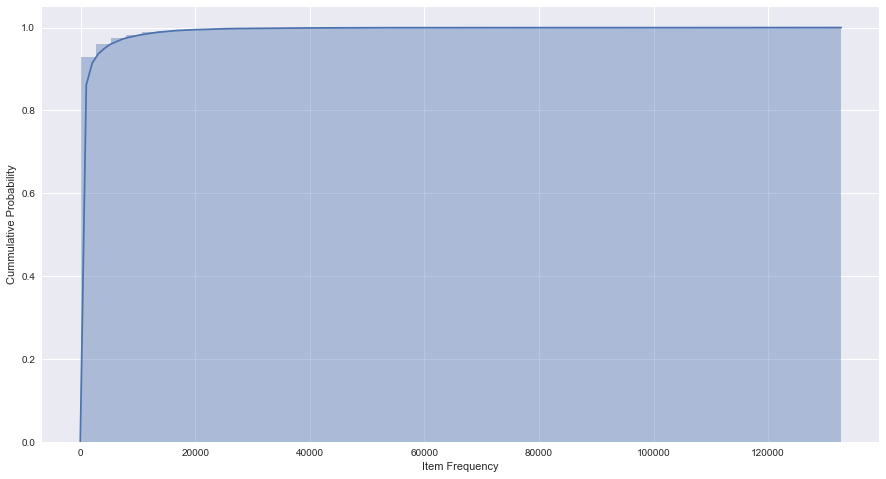

In [11]:
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111)
ax = sns.kdeplot(df_item_count["value"], ax=ax)
ax.set(xlabel='Item Frequency', ylabel='Kernel Density Estimation')
plt.show()
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111)
ax = sns.distplot(df_item_count["value"],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax.set(xlabel='Item Frequency', ylabel='Cummulative Probability')
plt.show()

In [12]:
# Let's analyze the co-occurrence
df_cooccurrence = data.copy()
df_cooccurrence["next_SessionId"] = df_cooccurrence["SessionId"].shift(-1)
df_cooccurrence["next_ItemId"] = df_cooccurrence["ItemId"].shift(-1)
df_cooccurrence["next_Time"] = df_cooccurrence["Time"].shift(-1)
df_cooccurrence = df_cooccurrence.query("SessionId == next_SessionId").dropna()
df_cooccurrence["next_ItemId"] = df_cooccurrence["next_ItemId"].astype(int)
df_cooccurrence["next_SessionId"] = df_cooccurrence["next_SessionId"].astype(int)

In [13]:
df_cooccurrence.head()

,SessionId,ItemId,Time,next_SessionId,next_ItemId,next_Time
0,1,214536502,1.396857e+09,1,214536500,1.396857e+09
1,1,214536500,1.396857e+09,1,214536506,1.396857e+09
2,1,214536506,1.396857e+09,1,214577561,1.396857e+09
4,2,214662742,1.396868e+09,2,214662742,1.396868e+09
5,2,214662742,1.396868e+09,2,214825110,1.396868e+09


In [14]:
df_cooccurrence["time_difference_minutes"] = np.round((df_cooccurrence["next_Time"] - df_cooccurrence["Time"]) / 60, 2)
df_cooccurrence[["time_difference_minutes"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time_difference_minutes,23670982.0,2.476333,5.434214,0.0,0.45,0.98,2.16,108.4


In [15]:
df_cooccurrence["value"] = 1
df_cooccurrence_sum = df_cooccurrence[["ItemId","next_ItemId","value"]].groupby(["ItemId","next_ItemId"]).sum().reset_index()

In [16]:
df_cooccurrence_sum[["value"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,3706018.0,6.387174,78.06891,1.0,1.0,1.0,2.0,71095.0


### Training GRU

In [17]:
n_layers = 100
save_to = os.path.join(os.path.dirname(PATH_TO_TEST), "gru_" + str(n_layers) +".pickle")

In [18]:
if not os.path.exists(save_to):
    print('Training GRU4Rec with ' + str(n_layers) + ' hidden units')    
    gru = gru4rec.GRU4Rec(layers=[n_layers], loss='top1', batch_size=50, 
                          dropout_p_hidden=0.5, learning_rate=0.01, momentum=0.0)
    gru.fit(data)
    pickle.dump(gru, open(save_to, "wb"))
else:
    print('Loading existing GRU4Rec model with ' + str(n_layers) + ' hidden units')    
    gru = pickle.load(open(save_to, "rb"))

Loading existing GRU4Rec model with 100 hidden units


### Evaluating GRU 

In [19]:
res = evaluation.evaluate_sessions_batch(gru, valid, None,cut_off=20)

In [20]:
print('The proportion of cases having the desired item within the top 20 (i.e Recall@20): {}'.format(res[0]))

The proportion of cases having the desired item within the top 20 (i.e Recall@20): 0.5858170238648968


In [37]:
batch_size = 500
print("Now let's try to predict over the first %i items of our testint dataset" % batch_size)

Now let's try to predict over the first 500 items of our testint dataset


In [38]:
df_valid = valid.head(batch_size)
df_valid["next_ItemId"] = df_valid["ItemId"].shift(-1)
df_valid["next_SessionId"] = df_valid["SessionId"].shift(-1)

C:\Users\frede\Anaconda3\envs\tf\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\frede\Anaconda3\envs\tf\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [39]:
session_ids = valid.head(batch_size)["SessionId"].values
input_item_ids = valid.head(batch_size)["ItemId"].values
predict_for_item_ids=None

In [40]:
%timeit gru.predict_next_batch(session_ids=session_ids, input_item_ids=input_item_ids, predict_for_item_ids=None, batch=batch_size)

1 loop, best of 3: 117 ms per loop


In [41]:
df_preds = gru.predict_next_batch(session_ids=session_ids, 
                      input_item_ids=input_item_ids,
                      predict_for_item_ids=None,
                      batch=batch_size)

In [42]:
df_valid.shape

(500, 5)

In [43]:
df_preds.shape

(37483, 500)

In [44]:
df_preds.columns = df_valid.index.values

In [45]:
len(items_training)

37483

In [46]:
df_preds

,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,...,2389,2390,2391,2392,2393,2394,2395,2396,2397,2398
214536502,-0.125554,-0.408401,0.241020,0.241020,-0.389289,-0.078933,-0.477493,0.232484,0.206817,0.244041,...,-0.428196,-0.428196,0.041961,0.098071,0.093519,0.206817,0.172675,0.241020,0.244041,0.157720
214536500,-0.288342,-0.476986,-0.033407,-0.033407,-0.438548,-0.090349,-0.567015,-0.091533,-0.091895,-0.021272,...,-0.454540,-0.454540,-0.027286,0.039859,-0.021722,-0.091895,-0.043099,-0.033407,-0.021272,-0.176717
214536506,-0.075021,-0.248366,0.054361,0.054361,-0.132804,0.056726,-0.488294,0.042792,0.003332,0.066164,...,-0.121433,-0.121433,0.014222,0.077800,0.050395,0.003332,0.040057,0.054361,0.066164,0.006859
214577561,-0.161591,-0.146989,-0.196368,-0.196368,-0.388048,-0.133704,-0.588967,-0.203824,-0.229023,-0.147396,...,-0.396826,-0.396826,-0.024899,0.042182,0.031068,-0.229023,-0.196541,-0.196368,-0.147396,-0.293953
214662742,-0.260508,-0.274328,-0.163363,-0.163363,-0.321595,-0.315299,0.224851,-0.140010,-0.107890,-0.167530,...,-0.324400,-0.324400,-0.247865,-0.334929,-0.402040,-0.107890,-0.223965,-0.163363,-0.167530,-0.226684
214825110,-0.352469,-0.434315,-0.339463,-0.339463,-0.224969,-0.303880,0.225020,-0.335964,-0.273014,-0.322670,...,-0.217162,-0.217162,-0.044710,-0.104694,-0.070252,-0.273014,-0.318397,-0.339463,-0.322670,-0.366161
214757390,-0.315072,-0.454990,-0.384481,-0.384481,-0.208142,-0.265650,0.229417,-0.396358,-0.307024,-0.370609,...,-0.199074,-0.199074,-0.028521,-0.094057,-0.071392,-0.307024,-0.350611,-0.384481,-0.370609,-0.435374
214757407,-0.278239,-0.443837,-0.200937,-0.200937,-0.136003,-0.180628,0.173040,-0.188200,-0.115801,-0.192596,...,-0.133456,-0.133456,0.050056,-0.020577,0.019239,-0.115801,-0.194293,-0.200937,-0.192596,-0.272369
214551617,-0.307604,-0.471146,-0.440282,-0.440282,-0.299050,-0.366722,-0.284910,-0.401151,-0.419496,-0.469510,...,-0.288231,-0.288231,-0.430822,-0.463243,-0.441564,-0.419496,-0.518069,-0.440282,-0.469510,-0.464533
214716935,-0.173355,-0.442302,-0.038002,-0.038002,-0.259541,-0.053066,-0.245974,-0.148393,-0.062892,-0.154969,...,-0.287357,-0.287357,-0.017233,-0.115849,-0.019306,-0.062892,-0.102994,-0.038002,-0.154969,-0.116428


In [47]:
for c in df_preds:
    df_preds[c] = df_preds[c].rank(ascending=False)

In [54]:
df_valid_preds = df_valid.join(df_preds.transpose())
df_valid_preds = df_valid_preds.query("SessionId == next_SessionId").dropna()
df_valid_preds["next_ItemId"] = df_valid_preds["next_ItemId"].astype(int)
df_valid_preds["next_SessionId"] = df_valid_preds["next_SessionId"].astype(int)
df_valid_preds["next_ItemId_at"] = df_valid_preds.apply(lambda x: x[int(x["next_ItemId"])], axis=1)
df_valid_preds_summary = df_valid_preds[["SessionId","ItemId","Time","next_ItemId","next_ItemId_at"]]
df_valid_preds_summary.head(10)

,SessionId,ItemId,Time,next_ItemId,next_ItemId_at
3742,11255568,214696432,1.411987e+09,214857030,468.0
3744,11255571,214858854,1.411962e+09,214858854,1.0
3746,11255572,214836819,1.411999e+09,214696434,36.0
3748,11255599,214857570,1.411962e+09,214858847,9752.0
3749,11255599,214858847,1.411963e+09,214859094,5.0
3750,11255599,214859094,1.411963e+09,214690730,3.0
3751,11255599,214690730,1.411963e+09,214859872,15.0
3753,11255661,214854705,1.412007e+09,214854705,1.0
3710,11255731,214857030,1.412027e+09,214696432,622.0
3711,11255731,214696432,1.412027e+09,214696432,1.0


In [60]:
cutoff = 20
df_valid_preds_summary_ok = df_valid_preds_summary.query("next_ItemId_at <= @cutoff")
df_valid_preds_summary_ok.head(10)

,SessionId,ItemId,Time,next_ItemId,next_ItemId_at
3744,11255571,214858854,1.411962e+09,214858854,1.0
3749,11255599,214858847,1.411963e+09,214859094,5.0
3750,11255599,214859094,1.411963e+09,214690730,3.0
3751,11255599,214690730,1.411963e+09,214859872,15.0
3753,11255661,214854705,1.412007e+09,214854705,1.0
3711,11255731,214696432,1.412027e+09,214696432,1.0
3712,11255731,214696432,1.412027e+09,214587952,6.0
3721,11255754,214858847,1.411976e+09,214859872,9.0
3722,11255754,214859872,1.411976e+09,214858847,19.0
3723,11255754,214858847,1.411976e+09,214859094,5.0


In [70]:
recall_at_k = df_valid_preds_summary_ok.shape[0] / df_valid_preds_summary.shape[0]
print("The recall@%i for this batch is %f"%(cutoff,recall_at_k))

The recall@20 for this batch is 0.559585


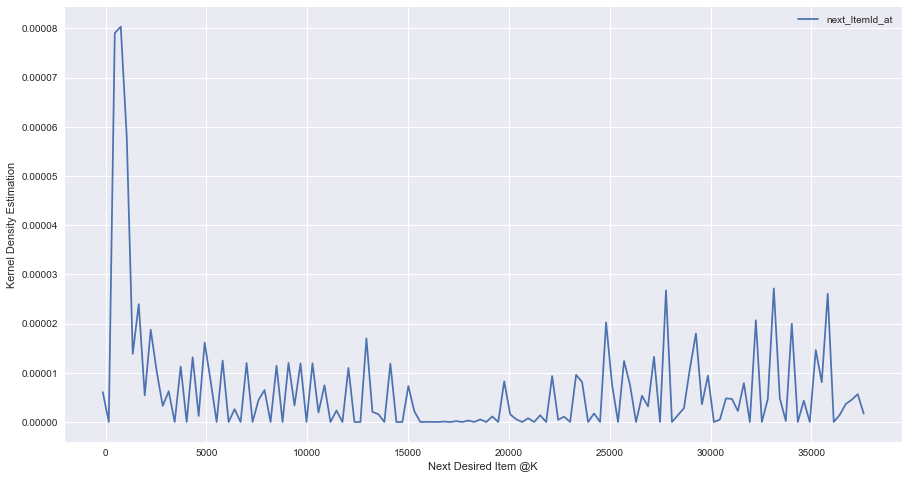

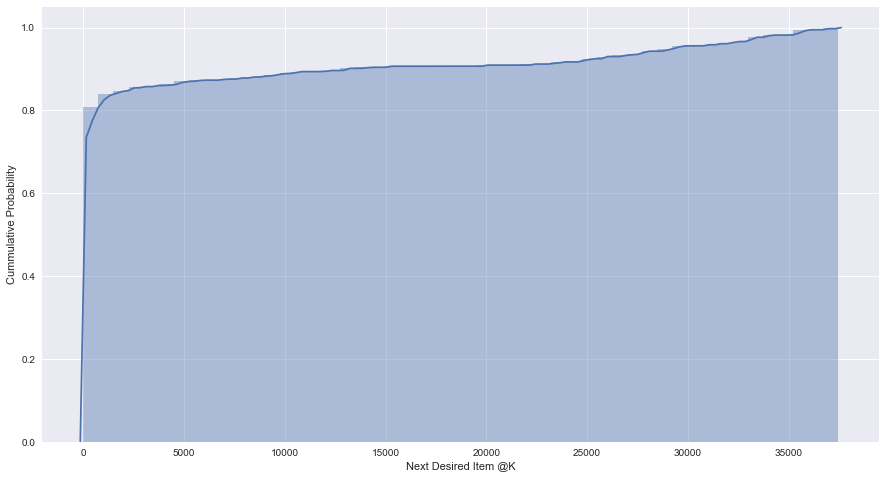

In [74]:
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111)
ax = sns.kdeplot(df_valid_preds_summary["next_ItemId_at"], ax=ax)
ax.set(xlabel='Next Desired Item @K', ylabel='Kernel Density Estimation')
plt.show()
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111)
ax = sns.distplot(df_valid_preds_summary["next_ItemId_at"],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax.set(xlabel='Next Desired Item @K', ylabel='Cummulative Probability')
plt.show()

In [72]:
print("Statistics for the rank of the next desired item (Lower the best)")
df_valid_preds_summary[["next_ItemId_at"]].describe()

Statistics for the rank of the next desired item (Lower the best)


,next_ItemId_at
count,386.000000
mean,3347.033679
std,8905.124331
min,1.000000
25%,4.000000
50%,15.500000
75%,205.750000
max,37454.000000
